# Predictor de Popularidade de Músicas

**Índice**<a id='toc0_'></a>    
1. [Introdução](#toc1_)    
2. [Preparação do notebook para R e Python em sumultâneo](#toc2_)    
3. [Importação dos módulos](#toc3_)    
4. [Exploração dos dados em bruto](#toc4_)    
4.1. [Upload dos dados](#toc4_1_)    
4.2. [Criação do dataframe](#toc4_2_)    
4.3. [Visualização do dataframe em bruto e de algumas métricas](#toc4_3_)    
5. [Análise Exploratória](#toc5_)    
5.1. [Distribuição dos valores em cada coluna](#toc5_1_)    
6. [Pré-processamento dos dados](#toc6_)    
6.1. [Identificação de Valores Ausentes](#toc6_1_)    
6.2. [Remoção de musicas com tempo 0](#toc6_2_)    
6.3. [Identificação e remoção de duplicados](#toc6_3_)    
6.4. [Definir o índice](#toc6_4_)    
6.5. [Remover coluna song_name](#toc6_5_)    
6.6. [Definir variáveis categóricas e variáveis numéricas](#toc6_6_)    
6.7. [Método do intervalo interquartil (IQR) para filtrar outliers](#toc6_7_)    
6.8. [Remoção de outliers com o z-score](#toc6_8_)    
6.9. [Remoção de outliers com Local Outlier Factor (LOF)](#toc6_9_)    
6.10. [Remoção de outliers variável a variável](#toc6_10_)    
6.11. [Gráficos comparativos da remoção dos outliers com os diferentes métodos](#toc6_11_)    
6.12. [Inferência](#toc6_12_)    
6.13. [Estatísticas do dataset](#toc6_13_)    
6.14. [Divisão das variáveis dependentes e independentes](#toc6_14_)    
7. [Divisão em conjunto de treino e conjunto de teste](#toc7_)    
8. [Implementação de algoritmos de Aprendizagem Computacional](#toc8_)    
8.1. [Random Forest](#toc8_1_)    
8.1.1. [Treino inicial do modelo](#toc8_1_1_)    
8.1.2. [Matriz de confusão](#toc8_1_2_)    
8.1.3. [Afinação dos hiperparâmetros com o Grid Search Cross Validation](#toc8_1_3_)    
8.1.4. [Configurar e executar o Grid Search Cross Validation](#toc8_1_4_)    
8.1.5. [Treino do modelo com os melhores hiperparâmetros](#toc8_1_5_)    
9. [Resultados](#toc9_)    
10. [Considerações finais](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introdução](#toc0_)

## 2. <a id='toc2_'></a>[Preparação do notebook para R e Python em sumultâneo](#toc0_)

In [121]:
# ! R -e "install.packages('IRkernel', repos = 'http://cran.us.r-project.org');IRkernel::installspec()"

In [122]:
# ! pip install rpy2

In [123]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [124]:
#%%R -i df_no_outliers
#head(df_no_outliers) #Exemplo de utilização

## 3. <a id='toc3_'></a>[Importação dos módulos](#toc0_)

In [125]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


## 4. <a id='toc4_'></a>[Exploração dos dados em bruto](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Upload dos dados](#toc0_)

In [126]:
data = pd.read_csv('data/song_data.csv')

### 4.2. <a id='toc4_2_'></a>[Criação do dataframe](#toc0_)

In [127]:
df_raw = pd.DataFrame(data)

In [128]:
df_raw

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


### 4.3. <a id='toc4_3_'></a>[Visualização do dataframe em bruto e de algumas métricas](#toc0_)

In [129]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In [130]:
df_raw.shape

(18835, 15)

## 5. <a id='toc5_'></a>[Análise Exploratória](#toc0_)

### 5.1. <a id='toc5_1_'></a>[Distribuição dos valores em cada coluna](#toc0_)

In [131]:
col_names = df_raw.columns

col_names

Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')

In [132]:
col_counts = {}

for col in col_names:
    col_counts[col] = df_raw[col].value_counts()

col_counts


{'song_name': song_name
 Better                                            21
 FEFE (feat. Nicki Minaj & Murda Beatz)            19
 MIA (feat. Drake)                                 18
 Taki Taki (with Selena Gomez, Ozuna & Cardi B)    18
 No Stylist                                        17
                                                   ..
 Bassride                                           1
 The Beat                                           1
 We Are the Brave - Fatum Remix                     1
 Long Live House Music                              1
 Up to Me                                           1
 Name: count, Length: 13070, dtype: int64,
 'song_popularity': song_popularity
 58     404
 52     389
 55     388
 60     383
 63     378
       ... 
 98      47
 97      36
 93      32
 99      16
 100     12
 Name: count, Length: 101, dtype: int64,
 'song_duration_ms': song_duration_ms
 165000    25
 180000    21
 212500    20
 189000    20
 179404    19
           ..
 219682 

## 6. <a id='toc6_'></a>[Pré-processamento dos dados](#toc0_)

### 6.1. <a id='toc6_1_'></a>[Identificação de Valores Ausentes](#toc0_)

In [133]:
df_raw.isnull().sum()

song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

### 6.2. <a id='toc6_2_'></a>[Remoção de musicas com tempo 0](#toc0_)

In [134]:
df_raw.drop(df_raw[(df_raw['tempo']==0)].index, inplace=True)

### 6.3. <a id='toc6_3_'></a>[Identificação e remoção de duplicados](#toc0_)

In [135]:
# Remover duplicatas considerando todas as colunas
df_raw.drop_duplicates(inplace=True)


In [136]:
df_raw.shape

(14924, 15)

### 6.4. <a id='toc6_4_'></a>[Definir o índice](#toc0_)

In [137]:
df_raw.set_index(pd.RangeIndex(start=1, stop=len(df_raw)+1, step=1), inplace=True)

### 6.5. <a id='toc6_5_'></a>[Remover coluna song_name](#toc0_)

In [138]:
df_raw.drop(columns='song_name', inplace=True)


### 6.6. <a id='toc6_6_'></a>[Definir variáveis categóricas e variáveis numéricas](#toc0_)

In [139]:
from sklearn.compose import make_column_selector as selector
numerical_columns_selector = selector(dtype_exclude='category')
categorical_columns_selector = selector(dtype_include='category')

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [140]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df_raw) 
df_raw.loc[:,:] = scaled_values

/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_89504/2002791448.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.73 0.66 0.76 ... 0.23 0.55 0.6 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_raw.loc[:,:] = scaled_values
/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_89504/2002791448.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.13317862 0.10757461 0.11592129 ... 0.08799262 0.18390557 0.09437783]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_raw.loc[:,:] = scaled_values
/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_89504/2002791448.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.72727273 0.27272727 0.         ... 0.        

### 6.7. <a id='toc6_7_'></a>[Método do intervalo interquartil (IQR) para filtrar outliers](#toc0_)

In [141]:
numeric_columns = df_raw.select_dtypes(include='number')

# Calcula Q1, Q3 e IQR para cada coluna numérica
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Define os limites para identificar outliers
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR

# Identifica e remove outliers
outliers = ((numeric_columns < lower_bound) | (numeric_columns > upper_bound)).any(axis=1)
df_IQR = df_raw[~outliers]
df_IQR.shape

(8609, 14)

### 6.8. <a id='toc6_8_'></a>[Remoção de outliers com o z-score](#toc0_)

In [142]:
# Calcular os z-scores para todas as colunas
z_scores = np.abs(stats.zscore(df_raw))

# Definir um threshold para outliers (por exemplo, Z-score < 3)
threshold = 3

# Manter as linhas onde os z-scores são menores que o threshold para todas as colunas
df_Z = df_raw[(z_scores < threshold).all(axis=1)]

### 6.9. <a id='toc6_9_'></a>[Remoção de outliers com Local Outlier Factor (LOF)](#toc0_)

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Supondo que df_raw é o seu DataFrame carregado com várias colunas
# Se df_raw não estiver definido, você pode carregá-lo assim:
# df_raw = pd.read_csv('caminho/para/seu/arquivo.csv')

# Load the dataset
X = df_raw

# Create the LocalOutlierFactor model for outlier detection
lof_outlier = LocalOutlierFactor(n_neighbors=20)

# Fit the model to the data and predict the outlier scores for each data point
outlier_scores = lof_outlier.fit_predict(X)

# Identify the outlier data points
outlier_indices = outlier_scores == -1
print("Outlier indices:", outlier_indices)

# Remover os outliers do DataFrame
df_LOF = X[~outlier_indices]
df_LOF.shape

Outlier indices: [False False  True ... False False False]


(14819, 14)

### 6.10. <a id='toc6_10_'></a>[Remoção de outliers variável a variável](#toc0_)

### 6.11. <a id='toc6_11_'></a>[Gráficos comparativos da remoção dos outliers com os diferentes métodos](#toc0_)

/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_89504/28685086.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels(['With Outliers', 'Without Outliers'])
/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_89504/28685086.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels(['With Outliers', 'Without Outliers'])
/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_89504/28685086.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels(['With Outliers', 'Without Outliers'])
/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_89504/28685086.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. aft

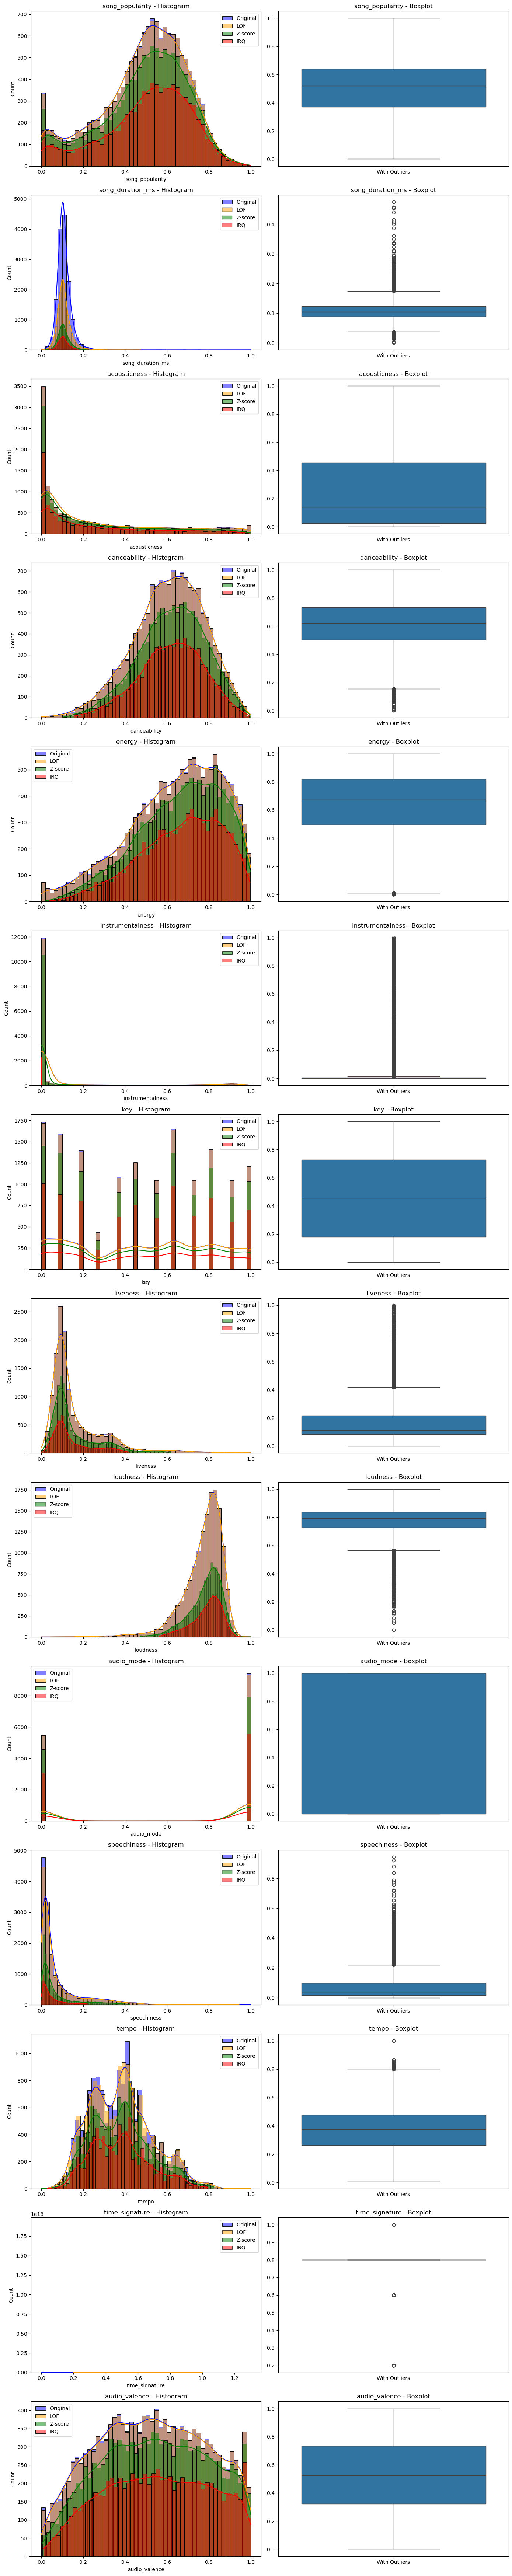

In [144]:
# Plot histograms and boxplots for each variable in a single image
variables = X.columns
num_vars = len(variables)

fig, axes = plt.subplots(num_vars, 2, figsize=(14, 5*num_vars))

for i, variable in enumerate(variables):
    # Histogram with and without outliers
    sns.histplot(X[variable], bins=50, kde=True, color='blue', ax=axes[i, 0], label='Original')
    sns.histplot(df_LOF[variable], bins=50, kde=True, color='orange', ax=axes[i, 0], label='LOF')
    sns.histplot(df_Z[variable], bins=50, kde=True, color='green', ax=axes[i, 0], label='Z-score')
    sns.histplot(df_IQR[variable], bins=50, kde=True, color='red', ax=axes[i, 0], label='IRQ')
    axes[i, 0].set_title(f'{variable} - Histogram')
    axes[i, 0].legend()

    # Boxplot with and without outliers
    sns.boxplot(data=[X[variable], df_LOF[variable]], ax=axes[i, 1])
    axes[i, 1].set_xticklabels(['With Outliers', 'Without Outliers'])
    axes[i, 1].set_title(f'{variable} - Boxplot')

plt.tight_layout()
plt.show()


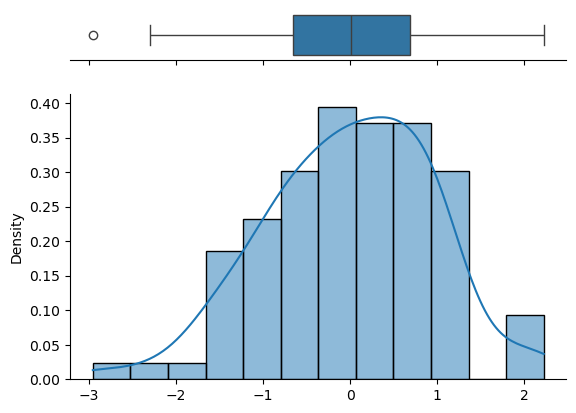

In [145]:
np.random.seed(2022)
x = np.random.randn(100)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=x, ax=ax_box)
sns.histplot(x=x, bins=12, kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

### 6.12. <a id='toc6_12_'></a>[Inferência](#toc0_)

Conjunto de dados inicial: 18835 amostras.

Com o método do Intervalo Interquartil: 

Com o método do Z-score:

Com o método do Local Outlier Factor:


### 6.13. <a id='toc6_13_'></a>[Estatísticas do dataset](#toc0_)

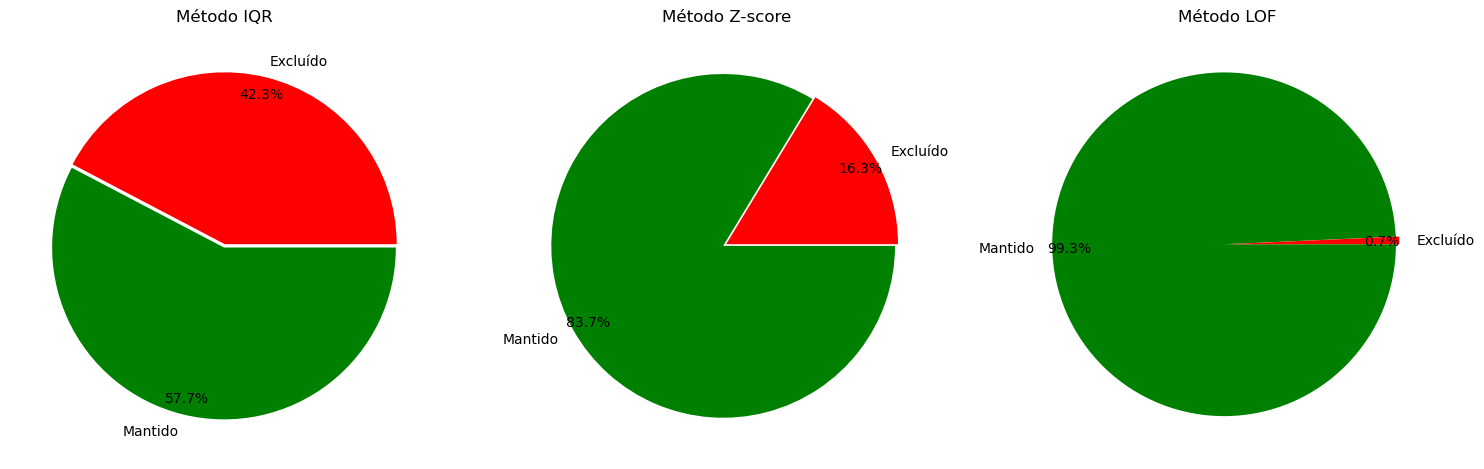

In [146]:
import matplotlib.pyplot as plt

# Definindo as cores
colors = ['green', 'red']  # Exemplo de cores: azul e laranja

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Criando uma figura com 3 subplots

# Gráfico para df_IQR
axes[0].set_title('Método IQR')
axes[0].pie([df_IQR.shape[0], df_raw.shape[0] - df_IQR.shape[0]],
            radius=1,
            labels=['Mantido', 'Excluído'],
            counterclock=False,
            autopct='%1.1f%%',
            pctdistance=0.9,
            explode=[0.02, 0],
            shadow=False,
            colors=colors)  # Adicionando a lista de cores

# Gráfico para df_Z
axes[1].set_title('Método Z-score')
axes[1].pie([df_Z.shape[0], df_raw.shape[0] - df_Z.shape[0]],
            radius=1,
            labels=['Mantido', 'Excluído'],
            counterclock=False,
            autopct='%1.1f%%',
            pctdistance=0.9,
            explode=[0.02, 0],
            shadow=False,
            colors=colors)  # Adicionando a lista de cores

# Gráfico para df_LOF
axes[2].set_title('Método LOF')
axes[2].pie([df_LOF.shape[0], df_raw.shape[0] - df_LOF.shape[0]],
            radius=1,
            labels=['Mantido', 'Excluído'],
            counterclock=False,
            autopct='%1.1f%%',
            pctdistance=0.9,
            explode=[0.02, 0],
            shadow=False,
            colors=colors)  # Adicionando a lista de cores

plt.tight_layout()  # Ajusta o layout para evitar sobreposição de legendas
plt.show()



### 6.14. <a id='toc6_14_'></a>[Divisão das variáveis dependentes e independentes](#toc0_)

In [147]:
# Splitting the data intro training & testing sets

from sklearn.model_selection import train_test_split

#m=[]
#for i in df_IQR.columns.values:
#    m.append(i.replace(' ','_'))
#    
#df_IQR.columns = m
#X = df_IQR[['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', #'tempo', 'time_signature', 'audio_valence']]
#X.loc[:, ['key', 'audio_mode', 'time_signature']] = X.loc[:, ['key', 'audio_mode', 'time_signature']].astype('category')
#Y = df_IQR["song_popularity"]



#m=[]
#for i in df_Z.columns.values:
#    m.append(i.replace(' ','_'))
#    
#df_Z.columns = m
#X = df_Z[['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', #'time_signature', 'audio_valence']]
#X.loc[:, ['key', 'audio_mode', 'time_signature']] = X.loc[:, ['key', 'audio_mode', 'time_signature']].astype('category')
#Y = df_Z["song_popularity"]




m=[]
for i in df_LOF.columns.values:
    m.append(i.replace(' ','_'))
    
df_LOF.columns = m
X = df_LOF[['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature', 'audio_valence']]
X.loc[:, ['key', 'audio_mode', 'time_signature']] = X.loc[:, ['key', 'audio_mode', 'time_signature']].astype('category')
Y = df_LOF["song_popularity"]



/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_89504/1782786501.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.727273, 0.272727, 0.000000, 0.909091, 0.363636, ..., 1.000000, 1.000000, 0.000000, 0.272727, 0.363636]
Length: 14819
Categories (12, float64): [0.000000, 0.090909, 0.181818, 0.272727, ..., 0.727273, 0.818182, 0.909091, 1.000000]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X.loc[:, ['key', 'audio_mode', 'time_signature']] = X.loc[:, ['key', 'audio_mode', 'time_signature']].astype('category')
/var/folders/km/dt_l1qsx1kvdth2cmx91yspm0000gn/T/ipykernel_89504/1782786501.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.8, 0.8, 0.8, 0.8, 0.8, ..., 0.8, 0.8, 0.8, 0.8, 0.8]
Length: 14819
Categories (4, float64): [0.2, 0.6, 0.8, 1.0]' has dtype incompatible with float64,

## 7. <a id='toc7_'></a>[Divisão em conjunto de treino e conjunto de teste](#toc0_)

In [148]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)
Train_X.reset_index(drop=True,inplace=True)

print('Conjunto original (100%): ',X.shape,Y.shape,'\nConjunto de treino (80%): ',Train_X.shape,Train_Y.shape,'\nConjunto de teste (20%): ', Test_X.shape,'', Test_Y.shape)

Conjunto original (100%):  (14819, 13) (14819,) 
Conjunto de treino (80%):  (11855, 13) (11855,) 
Conjunto de teste (20%):  (2964, 13)  (2964,)


## 8. <a id='toc8_'></a>[Implementação de algoritmos de Aprendizagem Computacional](#toc0_)

### 8.1. <a id='toc8_1_'></a>[Random Forest](#toc0_)

#### 8.1.1. <a id='toc8_1_1_'></a>[Treino inicial do modelo](#toc0_)

In [149]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn import set_config

# Escolha RandomForestClassifier para problemas de classificação e RandomForestRegressor para regressão
model = make_pipeline(RandomForestRegressor(random_state=21))  # ou RandomForestRegressor
set_config(display='diagram')

# Treinar o modelo
model.fit(Train_X, Train_Y)

# Fazer previsões
Pred_Y = model.predict(Test_X)
model



Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(random_state=21))])

In [150]:
def modelresults(predictions):
    mae = mean_absolute_error(Test_Y, predictions)
    mse = mean_squared_error(Test_Y, predictions)
    r2 = r2_score(Test_Y, predictions)
    
    print('Erro absoluto médio do modelo: {:.4f}'.format(mae))
    print('')
    print('Erro quadrático médio do modelo: {:.4f}'.format(mse))
    print('')
    print('O valor de r2 do modelo: {:.4f}'.format(r2))

#### Esquema árvore

In [151]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
 
# Assuming regressor is your trained Random Forest model
# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = model.estimators_[0]
 
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df_LOF.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

AttributeError: 'Pipeline' object has no attribute 'estimators_'

#### Performance

In [ ]:
modelresults(Pred_Y)

Erro absoluto médio do modelo: 0.1589

Erro quadrático médio do modelo: 0.0404

O valor de r2 do modelo: 0.0386


#### 8.1.2. <a id='toc8_1_2_'></a>[Matriz de confusão](#toc0_)

#### 8.1.3. <a id='toc8_1_3_'></a>[Afinação dos hiperparâmetros com o Grid Search Cross Validation](#toc0_)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],      # Número de árvores in the forest
    'max_features': ['sqrt', 'log2'],     # Número de features a serem consideradas para divisão
    'max_depth': [None, 10, 20, 30],      # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],      # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4]         # Número mínimo de amostras num nó folha
}


#### 8.1.4. <a id='toc8_1_4_'></a>[Configurar e executar o Grid Search Cross Validation](#toc0_)

In [ ]:
# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=21), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Executar o GridSearchCV
grid_search.fit(Train_X, Train_Y)

# Obter os melhores hiperparâmetros
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print(f"Melhor estimador: {best_estimator}")
print(f'Melhores hiperparâmetros: {best_params}')


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  10.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  20.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  20.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=

KeyboardInterrupt: 

#### 8.1.5. <a id='toc8_1_5_'></a>[Treino do modelo com os melhores hiperparâmetros](#toc0_)

In [ ]:
# Criar um novo modelo com os melhores hiperparâmetros
#best_model = RandomForestClassifier(**best_params, random_state=42)  # ou RandomForestRegressor
best_model = RandomForestRegressor(**best_params, random_state=42)  # ou RandomForestRegressor

# Treinar o modelo
best_model.fit(Train_X, Train_Y)

# Fazer previsões
Best_Pred_Y = best_model.predict(Test_X)


In [ ]:
modelresults(Best_Pred_Y)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Best_Pred_Y, Pred_Y),
                              display_labels=df_LOF.columns) 
cm.plot();

## 9. <a id='toc9_'></a>[Resultados](#toc0_)

## 10. <a id='toc10_'></a>[Considerações finais](#toc0_)